In [1]:
import os
os.environ['MKL_SERVICE_FORCE_INTEL'] = '1'

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from pyemd import emd
from pathlib import Path

import warnings 
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### EMD - Movement Class

In [2]:
class EMD_Movement:

    def __init__(self, path, normalization='None', bins=30):

        # Load the data
        data = pd.read_csv(path)
        tmp = list()
        for i, frame in data.groupby('frame'):
            tmp.append(frame)
        
        self.frames = tmp
        self.last_frame = len(self.frames) - 1

        # Set bins
        self.bins = bins

        # Extract the positions of the droplets in each frame
        self.positions = [np.array(frame[['center_x', 'center_y']].values, dtype=np.float64) for frame in self.frames]

        # Normalization of the droplet positions
        assert normalization in ['median', 'mean', 'None'], "Normalization must be either 'median' or 'mean' or 'none'"
        self.norm = normalization

        if self.norm == 'median':
            self.normalizer = data['radius'].median()

        elif self.norm == 'mean':
            self.normalizer = data['radius'].mean()

        else:
            self.normalizer = 1

        #  Normalize the positions by the median droplet radius
        for i in range(len(self.positions)):
            self.positions[i] /= self.normalizer

        self.emd_distances = None

    def emd_distance(self, source, target):
        # Compute the Earth Mover's Distance between two 2D point clouds

        # Get the maximum x and y coordinates
        self.x_max = max(np.max(source[:, 0]), np.max(target[:, 0]))
        self.y_max = max(np.max(source[:, 1]), np.max(target[:, 1]))

        # Convert 2D arrays to histograms (example using simple binning)
        hist1, xedges, yedges = np.histogram2d(source[:, 0], source[:, 1], bins=self.bins, range=[[0, self.x_max], [0, self.y_max]])
        hist2, _, _ = np.histogram2d(target[:, 0], target[:, 1], bins=self.bins, range=[[0, self.x_max], [0, self.y_max]])

        # Normalize histograms to create probability distributions
        self.hist1 = hist1 / np.sum(hist1)
        self.hist2 = hist2 / np.sum(hist2)

        # Flatten histograms to 1D arrays
        hist1_flat = self.hist1.flatten()
        hist2_flat = self.hist2.flatten()

        # Create a distance matrix using Euclidean distance
        bin_centers = np.array([(x, y) for x in (xedges[:-1] + xedges[1:]) / 2 for y in (yedges[:-1] + yedges[1:]) / 2])

        # Reshape bin_centers for broadcasting
        bin_centers_x = bin_centers[:, 0].reshape(-1, 1)
        bin_centers_y = bin_centers[:, 1].reshape(-1, 1)

        # Compute the squared differences in a vectorized manner
        diff_x = bin_centers_x - bin_centers_x.T
        diff_y = bin_centers_y - bin_centers_y.T

        # Compute the distance matrix
        distance_matrix = np.sqrt(diff_x ** 2 + diff_y ** 2)

        # Calculate the Earth Mover's Distance
        emd_dist = emd(hist1_flat, hist2_flat, distance_matrix)

        return emd_dist
    
    def emd_(self, first_frame=0, last_frame=None, print_=True):

        if last_frame is None:
            last_frame = self.last_frame
                
        self.emd_distances = list()
        for i in range(first_frame, last_frame):
            source = self.positions[i]
            target = self.positions[i+1]
            self.emd_distances.append(self.emd_distance(source, target))

        self.emd_distances = np.array(self.emd_distances)

        if print_:
            print(f"Earth Mover's Distance with {self.bins} bins:")
            print(f"Mean: {np.mean(self.emd_distances):.3f} (std: {np.std(self.emd_distances):.3f})")
            print(f"Median: {np.median(self.emd_distances):.3f}")
            print(f"Normalized by the {self.norm} droplet radius: {self.normalizer:.3f}")
            print()

        return self.emd_distances
    
    def plot_emd(self, source_frame=0, target_frame=1):
        assert 0 <= source_frame < len(self.frames), f"source_frame must be in the range [0, {len(self.frames) - 1}]"
        assert 0 <= target_frame < len(self.frames), f"target_frame must be in the range [0, {len(self.frames) - 1}]"
        assert source_frame != target_frame, "source_frame and target_frame must be different"
        assert source_frame < target_frame, "source_frame must be less than target_frame"

        source = self.positions[source_frame]
        target = self.positions[target_frame]
    
        emd_ = self.emd_distance(source, target)

        source = source * self.normalizer
        target = target * self.normalizer

        max_x = max(np.max(source[:, 0]), np.max(target[:, 0]))
        max_y = max(np.max(source[:, 1]), np.max(target[:, 1]))
        # Plot the Droplets
        fig = plt.figure(figsize=(16, 8))
        gs = GridSpec(2, 4, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1])

        # Plot the both frames in one scatter plot
        ax1 = fig.add_subplot(gs[0:2, 0:2])
        ax1.set_title(f'Droplets in Source and Target frames with EMD: {emd_:.4f}', fontsize=16)
        ax1.scatter(source[:, 0], source[:, 1], alpha=0.6, c='blue', label=f'Source', s=10)
        ax1.scatter(target[:, 0], target[:, 1], alpha=0.6, c='red', label=f'Target)', s=10)
        ax1.set_xlim([0, max_x])
        ax1.set_ylim([0, max_y])
        ax1.invert_yaxis()  # Invert y-axis to make (0, 0) the top-left corner
        ax1.legend(loc='upper right')

        # Plot the histogram of the source frame
        ax2 = fig.add_subplot(gs[0, 2])
        ax2.set_title(f'2D-Histogram of Source frame', fontsize=16)
        ax2.hist2d(source[:, 0], source[:, 1], bins=self.bins, cmap='Blues')
        ax2.invert_yaxis()

        # Plot the histogram of the target frame
        ax3 = fig.add_subplot(gs[1, 2])
        ax3.set_title(f'2D-Histogram of Target frame', fontsize=16)
        ax3.hist2d(target[:, 0], target[:, 1], bins=self.bins, cmap='Reds')
        ax3.invert_yaxis()

        # Plot source frame scatter plot
        ax4 = fig.add_subplot(gs[0, 3])
        ax4.set_title(f'Droplets in Source frame', fontsize=16)
        ax4.scatter(source[:, 0], source[:, 1], alpha=0.6, c='blue', s=2)
        ax4.set_xlim([0, max_x])
        ax4.set_ylim([0, max_y])
        ax4.invert_yaxis()

        # Plot target frame scatter plot
        ax5 = fig.add_subplot(gs[1, 3])
        ax5.set_title(f'Droplets in Target frame', fontsize=16)
        ax5.scatter(target[:, 0], target[:, 1], alpha=0.6, c='red', s=2)
        ax5.set_xlim([0, max_x])
        ax5.set_ylim([0, max_y])
        ax5.invert_yaxis()

        plt.tight_layout()
        plt.show()

    def plot_positions(self):
        # Number of scatter plots
        num_plots = len(self.positions)

        # Determine the number of rows and columns
        cols = 4
        rows = (num_plots + cols - 1) // cols  # Ceiling division to get the number of rows

        fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows), sharex=True, sharey=True)

        # Flatten the axes array for easy iteration
        axes = axes.flatten()

        for i in range(num_plots):
            axes[i].scatter(self.positions[i][:, 0]*self.normalizer, self.positions[i][:, 1]*self.normalizer, s=3)
            axes[i].set_title(f'Frame {i}')
            axes[i].set_xlim([0, np.max(self.positions[i][:, 0]*self.normalizer)])
            axes[i].set_ylim([0, np.max(self.positions[i][:, 1]*self.normalizer)])
            axes[i].invert_yaxis()

        # Hide any unused subplots
        for j in range(num_plots, len(axes)):
            axes[j].invert_yaxis()
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

## Pixelshift Experiments

Earth Mover's Distance with 30 bins:
Mean: 13.357 (std: 0.000)
Median: 13.357



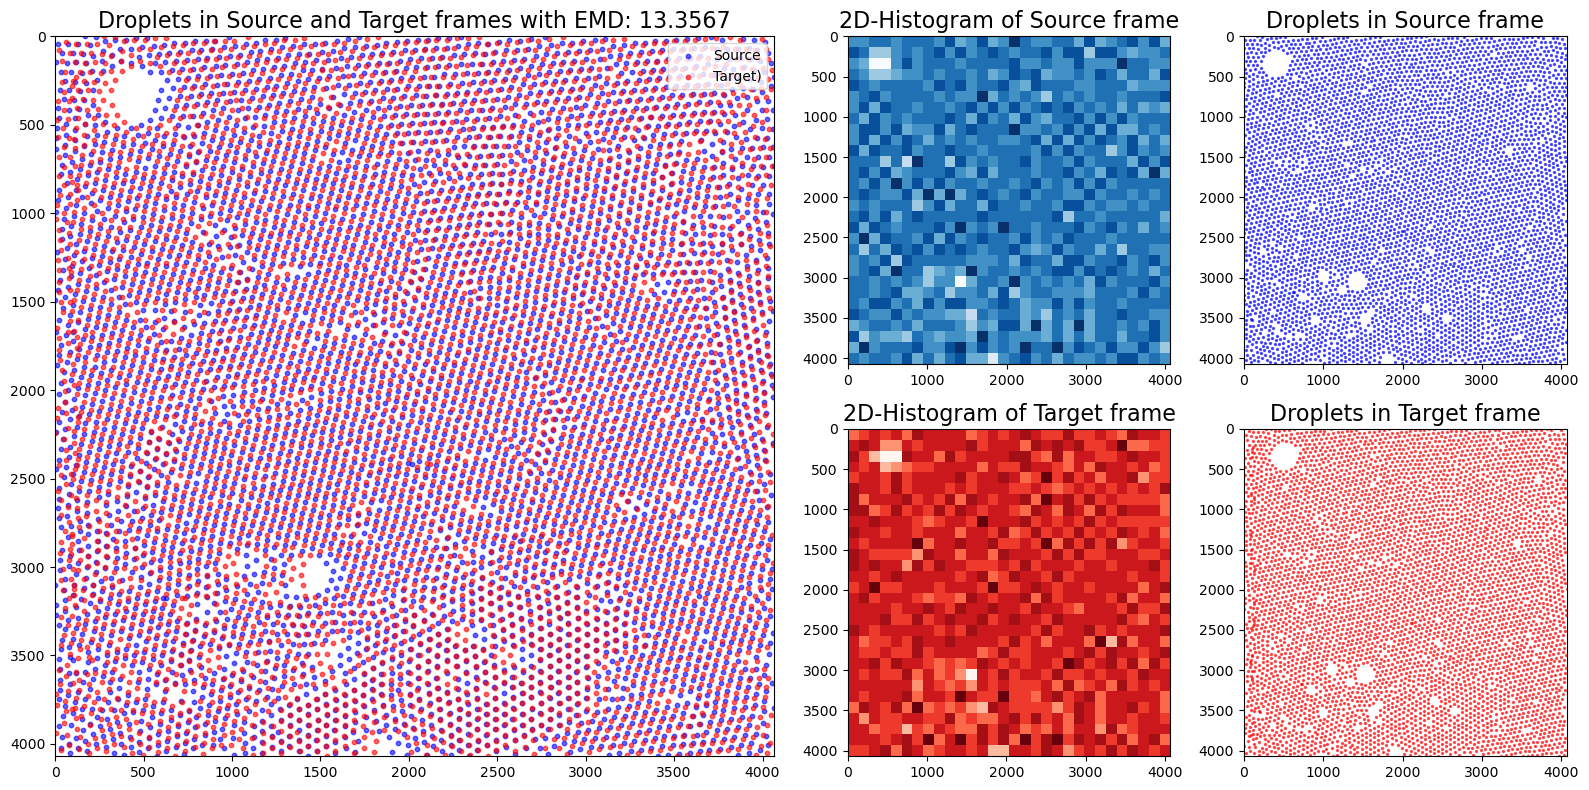

In [3]:
clip = 'Droplet_barcode_noMovement_Shift_100pixelright'
TEST_CLASS = EMD_Movement(Path(Path('data/03_features') / Path(clip) / 'droplets_y0_x0.csv'))

EMD_shift_50_dist = TEST_CLASS.emd_()
TEST_CLASS.plot_emd()

In [4]:
norm = TEST_CLASS.normalizer
test = TEST_CLASS.positions[0]

In [5]:
pos_max_x = np.max(test[:, 0])
pos_max_y = np.max(test[:, 1])

In [6]:
# get all droplets positions between 500/norm < x < 1500/norm and 500/norm < y < 1500/norm
test_cut_f1 = test[(test[:, 0] > 500/norm) & (test[:, 0] < 1500/norm) & (test[:, 1] > 500/norm) & (test[:, 1] < 1500/norm)]

In [7]:
# get all droplets positions between 2500/norm < x < 3500/norm and 500/norm < y < 1500/norm
test_cut_f2 = test[(test[:, 0] > 2500/norm) & (test[:, 0] < 3500/norm) & (test[:, 1] > 500/norm) & (test[:, 1] < 1500/norm)]

In [8]:
# shift all droplets in the first test cut by 500/norm in x and 1200/norm in y + some gaussian noise
test_cut_f3 = test_cut_f1 + np.random.normal(0, 1, test_cut_f1.shape) + np.array([500/norm, 1200/norm])

In [9]:
# get all droplets positions between 2500/norm < x < 3500/norm and 2500/norm < y < 3500/norm + some gaussian noise
test_cut_f4 = test[(test[:, 0] > 2500/norm) & (test[:, 0] < 3500/norm) & (test[:, 1] > 2500/norm) & (test[:, 1] < 3500/norm)]
test_cut_f4 = test_cut_f4 + np.random.normal(0, 1, test_cut_f4.shape)

In [10]:
# shift all droplets in the secund test cut by -250/norm in x and 0 in y + some gaussian noise
test_cut_f5 = test_cut_f2 + np.random.normal(0, 0.5, test_cut_f2.shape) + np.array([-250/norm, 0])

In [11]:
# shift all droplets in the first test cut by -50/norm in x and 0 in y + some gaussian noise
test_cut_f6 = test_cut_f1 + np.array([-50/norm, 0]) # + np.random.normal(0, 0.5, test_cut_f1.shape) 

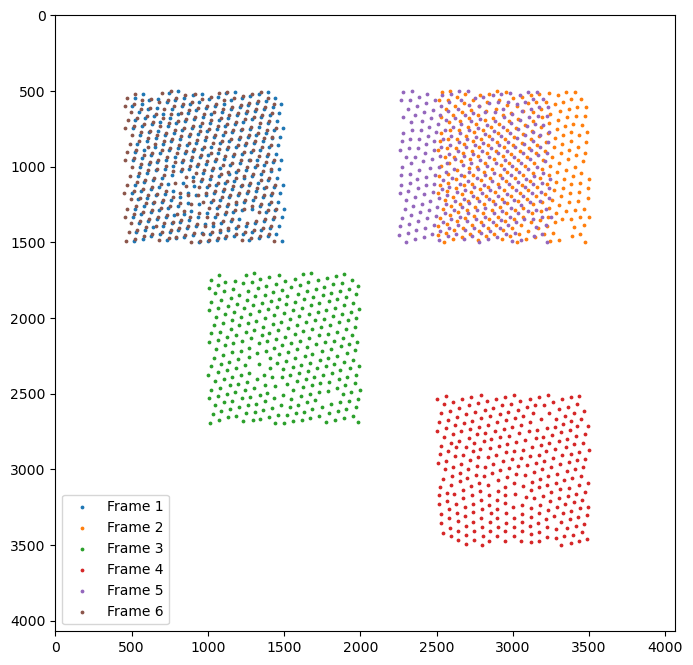

In [12]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

ax.scatter(test_cut_f1[:, 0], test_cut_f1[:, 1], s=3, label='Frame 1')
ax.scatter(test_cut_f2[:, 0], test_cut_f2[:, 1], s=3, label='Frame 2')
ax.scatter(test_cut_f3[:, 0], test_cut_f3[:, 1], s=3, label='Frame 3')
ax.scatter(test_cut_f4[:, 0], test_cut_f4[:, 1], s=3, label='Frame 4')
ax.scatter(test_cut_f5[:, 0], test_cut_f5[:, 1], s=3, label='Frame 5')
ax.scatter(test_cut_f6[:, 0], test_cut_f6[:, 1], s=3, label='Frame 6')

ax.set_xlim([0, pos_max_x])
ax.set_ylim([0, pos_max_y])
ax.invert_yaxis()
ax.legend()
plt.show()

In [13]:
def emd_distance(source, target, max_x, max_y, bins=30):
    # Compute the Earth Mover's Distance between two 2D point clouds

    # Convert 2D arrays to histograms (example using simple binning)
    hist1, xedges, yedges = np.histogram2d(source[:, 0], source[:, 1], bins=bins, range=[[0, max_x], [0, max_y]])
    hist2, _, _ = np.histogram2d(target[:, 0], target[:, 1], bins=bins, range=[[0, max_x], [0, max_y]])

    # Normalize histograms to create probability distributions
    hist1 = hist1 / np.sum(hist1)
    hist2 = hist2 / np.sum(hist2)

    # Flatten histograms to 1D arrays
    hist1_flat = hist1.flatten()
    hist2_flat = hist2.flatten()

    # Create a distance matrix using Euclidean distance
    bin_centers = np.array([(x, y) for x in (xedges[:-1] + xedges[1:]) / 2 for y in (yedges[:-1] + yedges[1:]) / 2])

    # Reshape bin_centers for broadcasting
    bin_centers_x = bin_centers[:, 0].reshape(-1, 1)
    bin_centers_y = bin_centers[:, 1].reshape(-1, 1)

    # Compute the squared differences in a vectorized manner
    diff_x = bin_centers_x - bin_centers_x.T
    diff_y = bin_centers_y - bin_centers_y.T

    # Compute the distance matrix
    distance_matrix = np.sqrt(diff_x ** 2 + diff_y ** 2)

    # Calculate the Earth Mover's Distance
    emd_dist = emd(hist1_flat, hist2_flat, distance_matrix)

    return emd_dist

In [14]:
# get all windows
# window f1 = 500/norm < x < 1500/norm and 500/norm < y < 1500/norm
avg_f1_x = (1500/norm + 500/norm)/2
avg_f1_y = (1500/norm + 500/norm)/2
# window f2 = 2500/norm < x < 3500/norm and 500/norm < y < 1500/norm
avg_f2_x = (3500/norm + 2500/norm)/2
avg_f2_y = (1500/norm + 500/norm)/2
# window f3 = 1000/norm < x < 2000/norm and 1700/norm < y < 2700/norm
avg_f3_x = (2000/norm + 1000/norm)/2
avg_f3_y = (2700/norm + 1700/norm)/2
# window f4 = 2500/norm < x < 3500/norm and 2500/norm < y < 3500/norm
avg_f4_x = (3500/norm + 2500/norm)/2
avg_f4_y = (3500/norm + 2500/norm)/2
# window f5 = 2250/norm < x < 3250/norm and 500/norm < y < 1500/norm
avg_f5_x = (3250/norm + 2250/norm)/2
avg_f5_y = (1500/norm + 500/norm)/2
# window f6 = 450/norm < x < 1450/norm and 500/norm < y < 1500/norm
avg_f6_x = (1450/norm + 450/norm)/2
avg_f6_y = (1500/norm + 500/norm)/2

In [15]:
# get all emd distances
emd_f1_f2 = emd_distance(test_cut_f1, test_cut_f2, pos_max_x, pos_max_y)
emd_f1_f3 = emd_distance(test_cut_f1, test_cut_f3, pos_max_x, pos_max_y)
emd_f1_f4 = emd_distance(test_cut_f1, test_cut_f4, pos_max_x, pos_max_y)
emd_f1_f5 = emd_distance(test_cut_f1, test_cut_f5, pos_max_x, pos_max_y)
emd_f2_f3 = emd_distance(test_cut_f2, test_cut_f3, pos_max_x, pos_max_y)
emd_f2_f4 = emd_distance(test_cut_f2, test_cut_f4, pos_max_x, pos_max_y)
emd_f2_f5 = emd_distance(test_cut_f2, test_cut_f5, pos_max_x, pos_max_y)
emd_f3_f4 = emd_distance(test_cut_f3, test_cut_f4, pos_max_x, pos_max_y)
emd_f3_f5 = emd_distance(test_cut_f3, test_cut_f5, pos_max_x, pos_max_y)
emd_f4_f5 = emd_distance(test_cut_f4, test_cut_f5, pos_max_x, pos_max_y)

In [16]:
emd_f1_f6 = emd_distance(test_cut_f1, test_cut_f6, pos_max_x, pos_max_y)
dist_f1_f6 = np.sqrt((avg_f1_x - avg_f6_x)**2 + (avg_f1_y - avg_f6_y)**2)
print(f"Distance between f1 and f6: {dist_f1_f6:.4f}")
print(f"EMD between f1 and f6: {emd_f1_f6:.4f}")
print(f"Ration between EMD and distance: {emd_f1_f6/dist_f1_f6:.4f}")

Distance between f1 and f6: 50.0000
EMD between f1 and f6: 47.4551
Ration between EMD and distance: 0.9491


In [17]:
# get all distances
dist_f1_f2 = np.sqrt((avg_f1_x - avg_f2_x)**2 + (avg_f1_y - avg_f2_y)**2)
dist_f1_f3 = np.sqrt((avg_f1_x - avg_f3_x)**2 + (avg_f1_y - avg_f3_y)**2)
dist_f1_f4 = np.sqrt((avg_f1_x - avg_f4_x)**2 + (avg_f1_y - avg_f4_y)**2)
dist_f1_f5 = np.sqrt((avg_f1_x - avg_f5_x)**2 + (avg_f1_y - avg_f5_y)**2)
dist_f2_f3 = np.sqrt((avg_f2_x - avg_f3_x)**2 + (avg_f2_y - avg_f3_y)**2)
dist_f2_f4 = np.sqrt((avg_f2_x - avg_f4_x)**2 + (avg_f2_y - avg_f4_y)**2)
dist_f2_f5 = np.sqrt((avg_f2_x - avg_f5_x)**2 + (avg_f2_y - avg_f5_y)**2)
dist_f3_f4 = np.sqrt((avg_f3_x - avg_f4_x)**2 + (avg_f3_y - avg_f4_y)**2)
dist_f3_f5 = np.sqrt((avg_f3_x - avg_f5_x)**2 + (avg_f3_y - avg_f5_y)**2)
dist_f4_f5 = np.sqrt((avg_f4_x - avg_f5_x)**2 + (avg_f4_y - avg_f5_y)**2)

In [18]:
# print EMD and distances and their ration
print(f"EMD f1-f2: {emd_f1_f2:.3f} -- distance: {dist_f1_f2:.3f} -- ratio: {emd_f1_f2/dist_f1_f2:.3f}")
print(f"EMD f1-f3: {emd_f1_f3:.3f} -- distance: {dist_f1_f3:.3f} -- ratio: {emd_f1_f3/dist_f1_f3:.3f}")
print(f"EMD f1-f4: {emd_f1_f4:.3f} -- distance: {dist_f1_f4:.3f} -- ratio: {emd_f1_f4/dist_f1_f4:.3f}")
print(f"EMD f1-f5: {emd_f1_f5:.3f} -- distance: {dist_f1_f5:.3f} -- ratio: {emd_f1_f5/dist_f1_f5:.3f}")
print(f"EMD f2-f3: {emd_f2_f3:.3f} -- distance: {dist_f2_f3:.3f} -- ratio: {emd_f2_f3/dist_f2_f3:.3f}")
print(f"EMD f2-f4: {emd_f2_f4:.3f} -- distance: {dist_f2_f4:.3f} -- ratio: {emd_f2_f4/dist_f2_f4:.3f}")
print(f"EMD f2-f5: {emd_f2_f5:.3f} -- distance: {dist_f2_f5:.3f} -- ratio: {emd_f2_f5/dist_f2_f5:.3f}")
print(f"EMD f3-f4: {emd_f3_f4:.3f} -- distance: {dist_f3_f4:.3f} -- ratio: {emd_f3_f4/dist_f3_f4:.3f}")
print(f"EMD f3-f5: {emd_f3_f5:.3f} -- distance: {dist_f3_f5:.3f} -- ratio: {emd_f3_f5/dist_f3_f5:.3f}")
print(f"EMD f4-f5: {emd_f4_f5:.3f} -- distance: {dist_f4_f5:.3f} -- ratio: {emd_f4_f5/dist_f4_f5:.3f}")

EMD f1-f2: 1996.0815 -- distance: 2000.0000 -- ratio: 0.9980
EMD f1-f3: 1296.5889 -- distance: 1300.0000 -- ratio: 0.9974
EMD f1-f4: 2825.6736 -- distance: 2828.4271 -- ratio: 0.9990
EMD f1-f5: 1745.7008 -- distance: 1750.0000 -- ratio: 0.9975
EMD f2-f3: 1914.6315 -- distance: 1920.9373 -- ratio: 0.9967
EMD f2-f4: 1996.5464 -- distance: 2000.0000 -- ratio: 0.9983
EMD f2-f5: 250.3955 -- distance: 250.0000 -- ratio: 1.0016
EMD f3-f4: 1699.2377 -- distance: 1700.0000 -- ratio: 0.9996
EMD f3-f5: 1726.6400 -- distance: 1732.7723 -- ratio: 0.9965
EMD f4-f5: 2012.7536 -- distance: 2015.5644 -- ratio: 0.9986


In [19]:
pos1 = TEST_CLASS.positions[0]
pos2 = pos1 + np.random.normal(0, 0.5, pos1.shape)
# get all droplets positions between 500/norm < x 
pos3 = pos1[(pos1[:, 0] > 500/norm)]

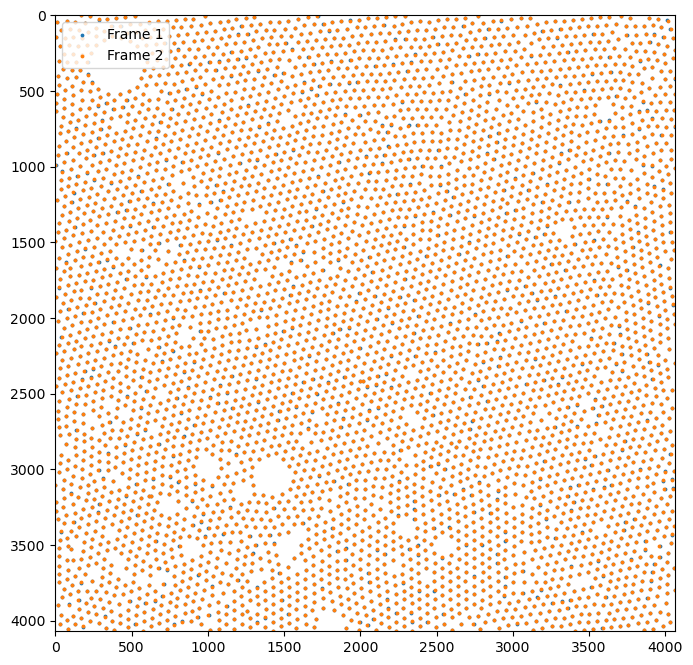

In [20]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

ax.scatter(pos1[:, 0], pos1[:, 1], s=3, label='Frame 1')
ax.scatter(pos2[:, 0], pos2[:, 1], s=3, label='Frame 2')
# ax.scatter(pos3[:, 0], pos3[:, 1], s=3, label='Frame 3')

ax.set_xlim([0, pos_max_x])
ax.set_ylim([0, pos_max_y])
ax.invert_yaxis()
ax.legend()
plt.show()

In [21]:
avg_dist_pos1_pos2 = np.mean(np.sqrt((pos1[:, 0] - pos2[:, 0])**2 + (pos1[:, 1] - pos2[:, 1])**2))
avg_dist_pos1_pos2

0.6303349444178429

In [22]:
emd_pos1_pos2 = emd_distance(pos1, pos2, pos_max_x, pos_max_y)
emd_pos1_pos2

1.2580538605990328